## YouTube Practice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading Data

In [5]:
data = pd.read_csv('heart.csv') #can include argument to parse dates parse_dates=['Dates']
data


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
data.shape

(918, 12)

In [9]:
data.info()    #similar to structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
data.describe()     #similar summary

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [11]:
data['Cholesterol'].describe()

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [12]:
data['Cholesterol'].mean()

198.7995642701525

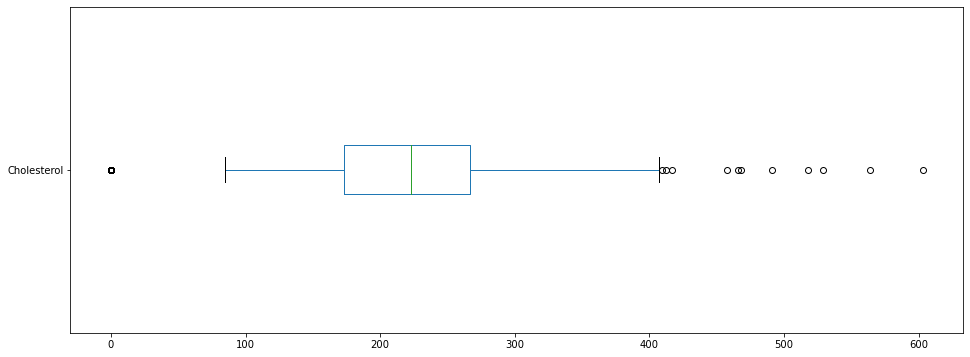

In [30]:
data['Cholesterol'].plot(kind='box', vert=False, figsize=(16,6));

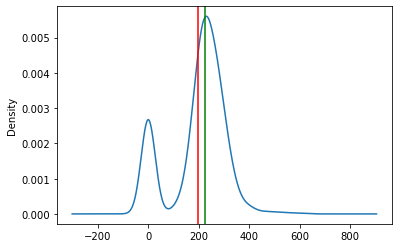

In [29]:
ax = data['Cholesterol'].plot(kind='density')
ax.axvline(data['Cholesterol'].mean(), color='red')
ax.axvline(data['Cholesterol'].median(), color='green');

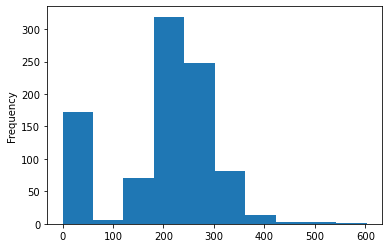

In [20]:
ax = data['Cholesterol'].plot(kind='hist')

In [21]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [22]:
data['Sex'].value_counts()

M    725
F    193
Name: Sex, dtype: int64

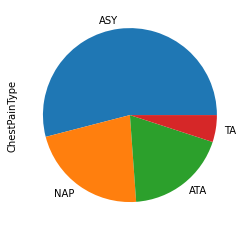

In [28]:
data['ChestPainType'].value_counts().plot(kind='pie');

In [25]:
corr=data.corr()         #doesn't include non-numeric automatically
corr

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


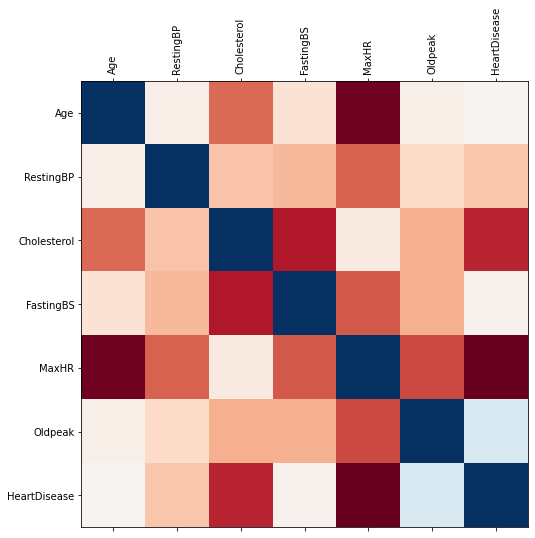

In [27]:
fig = plt.figure(figsize=(8,8))
plt.matshow(corr, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
plt.yticks(range(len(corr.columns)), corr.columns);

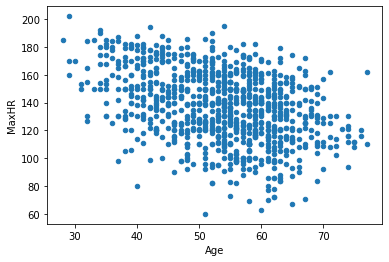

In [35]:
data.plot(kind='scatter', x='Age', y='MaxHR');

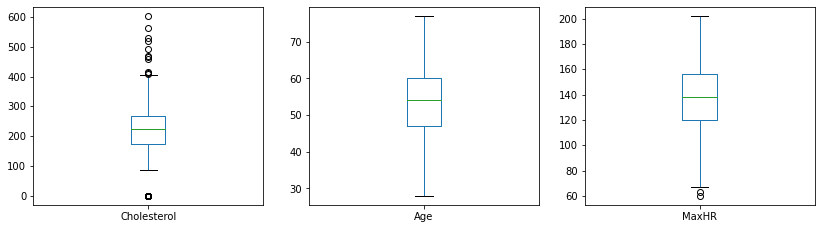

In [44]:
boxplot_cols = ['Cholesterol','Age','MaxHR']
data[boxplot_cols].plot(kind='box', subplots=True, layout=(2,3), figsize=(14,8));

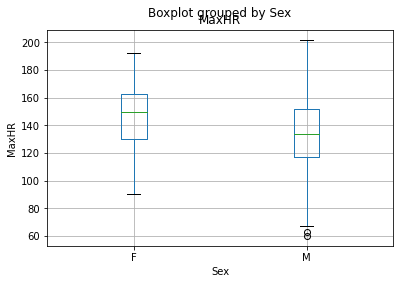

In [47]:
ax = data[['MaxHR', 'Sex']].boxplot(by='Sex')
ax.set_ylabel('MaxHR')
ax.set_xlabel('Sex');